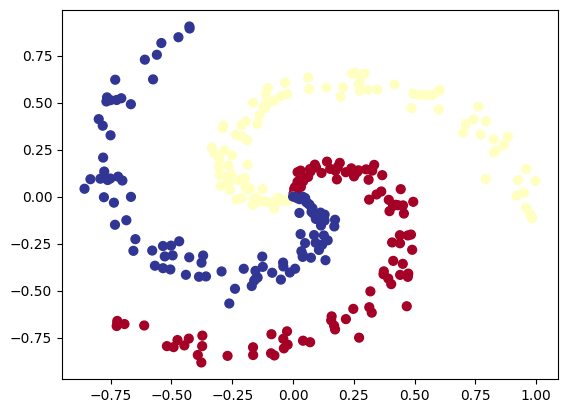

In [13]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# Let's visualize
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [14]:
import torch
from torch import nn

# Agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"

RANDOM_SEED = 20
IN_FEATURES = 2
OUT_FEATURES = 3
HIDDEN = 8

# Convert to tensors

X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

# Split dataset into train and test splits

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


In [15]:
# Construct the necessary model

class SpiralModelV0(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(in_features=IN_FEATURES, out_features=HIDDEN),
            nn.ReLU(),
            nn.Linear(in_features=HIDDEN, out_features=HIDDEN),
            nn.ReLU(),
            nn.Linear(in_features=HIDDEN, out_features=OUT_FEATURES)
        )
    
    def forward (self, x):
        return self.layers(x)

# start Model

model_0 = SpiralModelV0()

model_0

SpiralModelV0(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [16]:
# Loss function and Optimizer Setup

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.01)

In [22]:
# Training and testing loops!

torch.manual_seed(RANDOM_SEED)
import torchmetrics
from torchmetrics.classification import Accuracy

epochs = 1000

for epoch in range(epochs):

    ### Training
    model_0.train()

    X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

    # 1. Forward Pass 
    y_logits = model_0(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Loss and acc fns, as we use CELoss
    y_train = y_train.to(torch.long)
    loss = loss_fn(y_logits, y_train)
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=OUT_FEATURES)
    acc = metric(y_pred, y_train) * 100

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Step
    optimizer.step()

    ### Testing

    model_0.eval()

    # 1. Forward Pass
    y_logits = model_0(X_test).squeeze()
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Loss and acc fns
    y_test = y_test.to(torch.long)
    test_loss = loss_fn(y_logits, y_test) 
    test_acc = metric(y_pred, y_test) * 100

    # Print out what's happening

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.1152, Acc: 34.17% | Test Loss: 1.1241, Test Acc: 30.00%
Epoch: 100 | Loss: 0.6260, Acc: 70.42% | Test Loss: 0.7161, Test Acc: 60.00%
Epoch: 200 | Loss: 0.3111, Acc: 89.17% | Test Loss: 0.3243, Test Acc: 91.67%
Epoch: 300 | Loss: 0.1274, Acc: 97.50% | Test Loss: 0.1462, Test Acc: 98.33%
Epoch: 400 | Loss: 0.0872, Acc: 97.92% | Test Loss: 0.0871, Test Acc: 98.33%
Epoch: 500 | Loss: 0.0682, Acc: 97.92% | Test Loss: 0.0628, Test Acc: 98.33%
Epoch: 600 | Loss: 0.0553, Acc: 98.75% | Test Loss: 0.0556, Test Acc: 100.00%
Epoch: 700 | Loss: 0.0466, Acc: 98.75% | Test Loss: 0.0561, Test Acc: 98.33%
Epoch: 800 | Loss: 0.0401, Acc: 99.17% | Test Loss: 0.0532, Test Acc: 98.33%
Epoch: 900 | Loss: 0.0350, Acc: 99.17% | Test Loss: 0.0560, Test Acc: 98.33%


In [23]:
import numpy as np

def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

# This function allows us to visualise the data

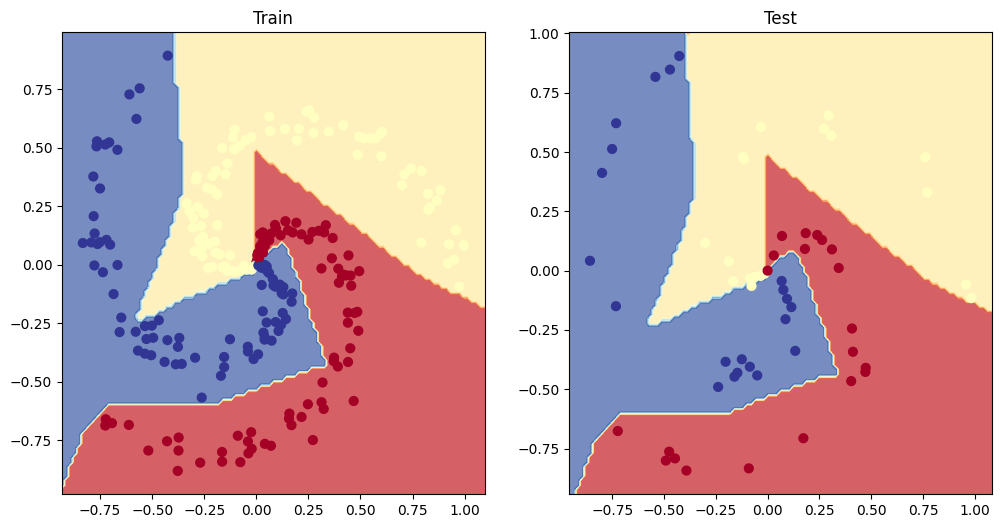

In [24]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)